In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from fredapi import Fred
import datetime
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

# Initialize FRED API
fred = Fred(api_key='8445855393be6d75a6d33bcddffc7958')


In [26]:

# Define the series IDs for the required data 
series_ids = {
    '5-Year, 5-Year Forward Inflation Expectation Rate': 'T5YIFR',
    '1 Year Treasury Rate': 'DGS1',
    'fed_balance_sheet_assets': 'WALCL',
    'gdp': 'GDP',
    'Summary of Economic Projections: Longer-Term Federal Funds Rate': 'FEDTARMDLR',
    'US 10yr': 'DGS10',
    'RRP': "WLRRAL",
    'US Treasury General Account' : 'D2WLTGAL'
}

# Fetch the data starting from 11/8/2021
start_date = '2021-11-08'

# Download data and store in a dictionary
data = {name: fred.get_series(series_id, observation_start=start_date) for name, series_id in series_ids.items()}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Resample the monthly GDP to daily frequency using forward fill method
df = df.ffill()

# Calculate the Fed Balance Sheet Assets to GDP ratio
df['Fed BS Assets to GDP'] = df['fed_balance_sheet_assets'] / (df['gdp'] * 1000)

# Calculate Net Liquidity Indicator
df['Net Liquidity Indicator'] = df['fed_balance_sheet_assets'] - df['RRP'] - df['US Treasury General Account']

# Drop unnecessary columns
df = df.drop(['fed_balance_sheet_assets', 'gdp', 'RRP', 'US Treasury General Account'], axis=1)
df = df.dropna()


In [27]:

# Define the target variable and the features
X = df.drop(columns=['US 10yr'])
y = df['US 10yr']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the regression tree and the parameter grid for grid search
reg_tree = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth': [3],
    'min_samples_split': [5 , 10],
    'min_samples_leaf': [ 5 , 10]
}


In [28]:

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=reg_tree, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)
# Get the best model
best_tree = grid_search.best_estimator_
print(best_tree)

DecisionTreeRegressor(max_depth=3, min_samples_leaf=5, min_samples_split=5,
                      random_state=42)


c:\Users\dstockman\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Model Parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
R^2: 0.9380348786699664
Adjusted R^2: 0.9376406985088338
Current 10-Year Yield: 4.4
Current 10-Year Yield Prediction: 4.0626
Percentile rank of the latest value: 94.70%


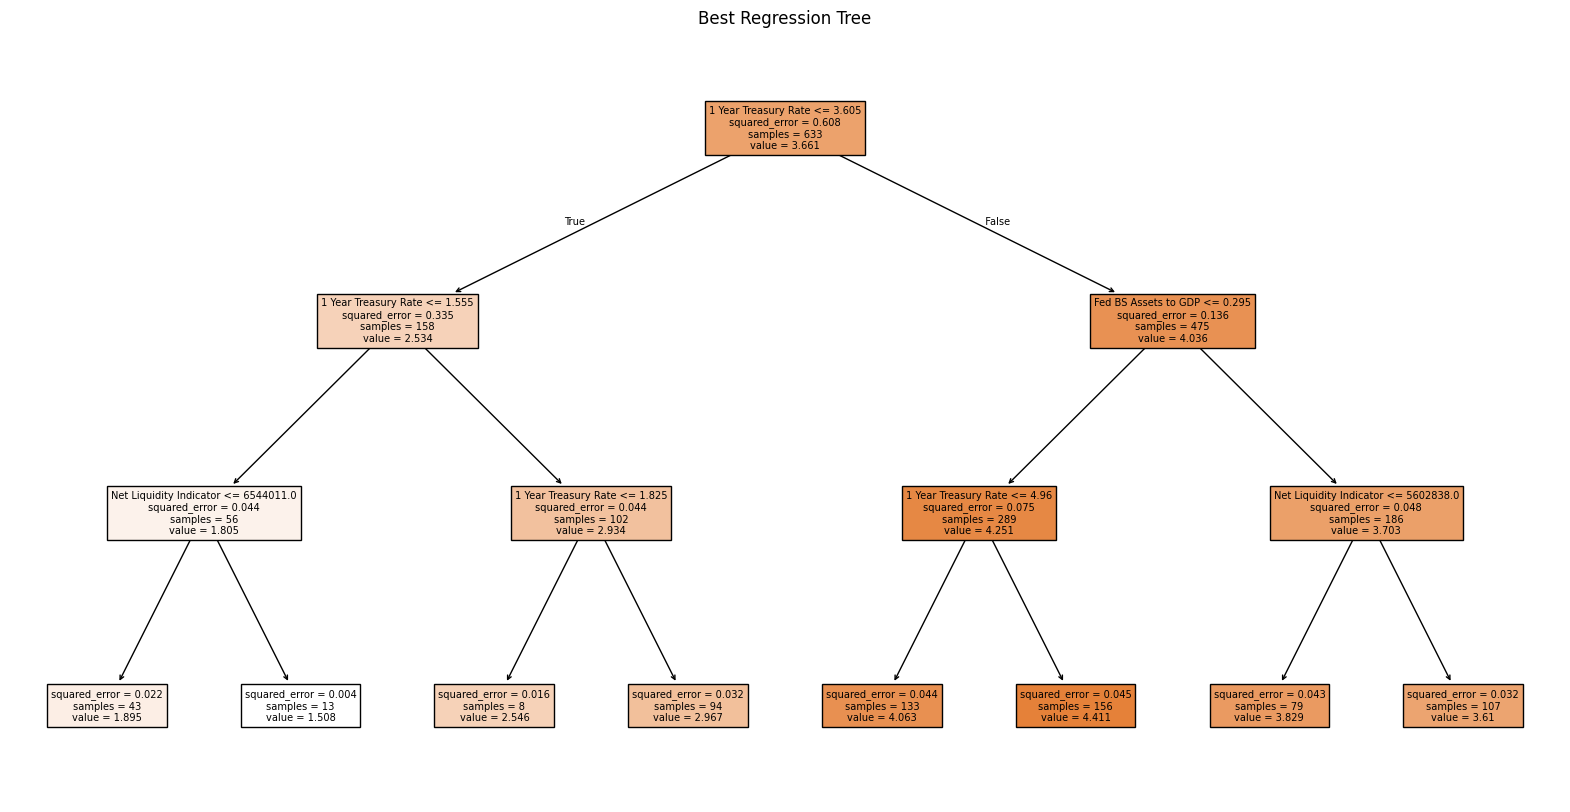

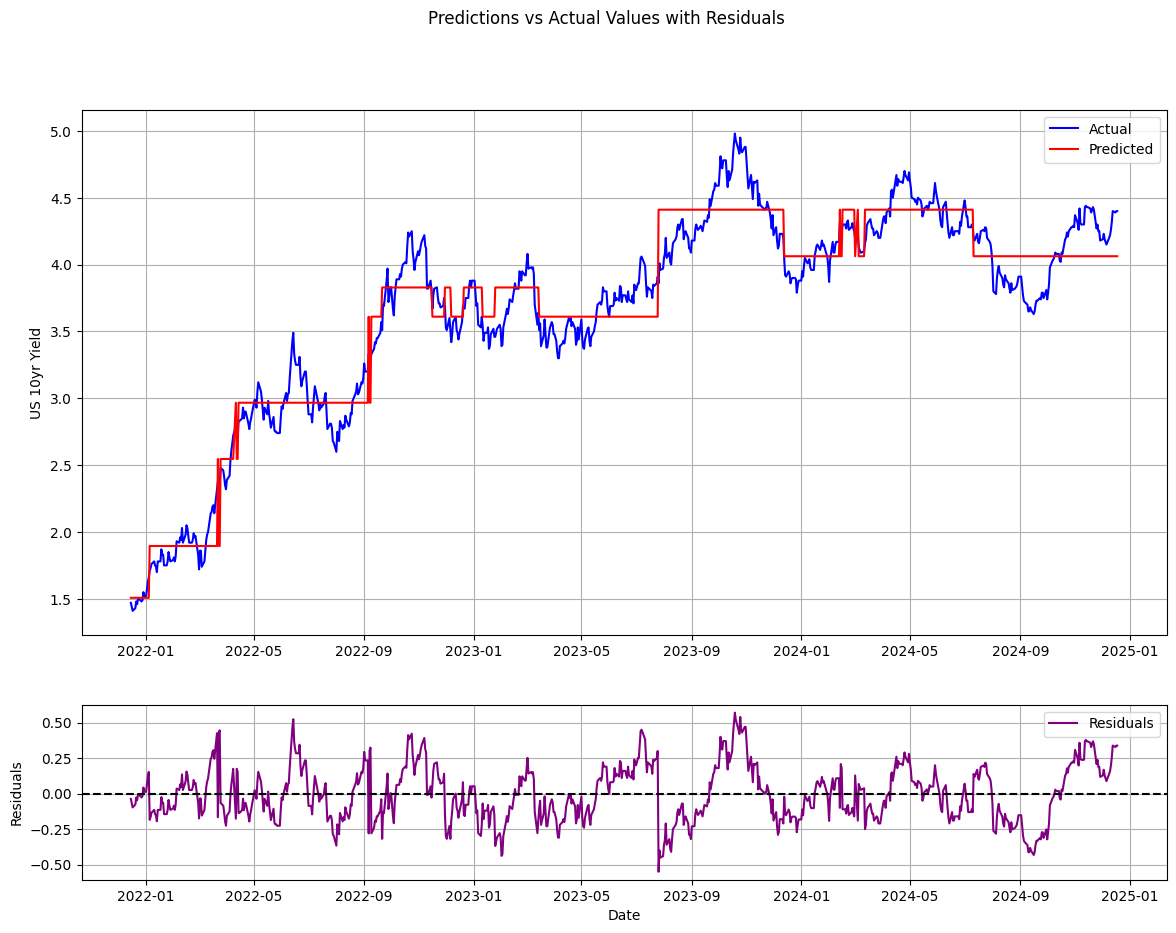

In [29]:
from sklearn.metrics import r2_score

# Make predictions on the test set
y_pred = best_tree.predict(X_test)
y_pred_all = best_tree.predict(X)  # Predictions on the entire dataset for metrics calculation

# Calculate R-squared and adjusted R-squared
r_squared = r2_score(y, y_pred_all)
n = X.shape[0]  # Number of observations
k = X.shape[1]  # Number of predictors
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)

# Display regression information and latest difference
print(f"Model Parameters: {best_tree.get_params()}")
print(f"R^2: {r_squared}")
print(f"Adjusted R^2: {adjusted_r_squared}")
print(f"Current 10-Year Yield: {round(y.iloc[-1], 4)}")
print(f"Current 10-Year Yield Prediction: {round(y_pred_all[-1], 4)}")

# Calculate residuals
residuals = y - y_pred_all

# Calculate the percentile rank for each value in the series
df['residuals'] = residuals
df['residual percentile_rank'] = df['residuals'].rank(pct=True) * 100

# Display the percentile rank for the latest value in the series
latest_value = df['residuals'].iloc[-1]
latest_percentile_rank = df['residual percentile_rank'].iloc[-1]
print(f"Percentile rank of the latest value: {latest_percentile_rank:.2f}%")

# Plot the best regression tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=X.columns, filled=True)
plt.title('Best Regression Tree')
plt.show()

# Plot predictions and actual values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})
fig.suptitle('Predictions vs Actual Values with Residuals')

# Plot predictions and actual values on the same chart
ax1.plot(df.index, y, label='Actual', color='blue')
ax1.plot(df.index, y_pred_all, label='Predicted', color='red')
ax1.set_ylabel('US 10yr Yield')
ax1.legend()
ax1.grid(True)

# Plot residuals
ax2.plot(df.index, residuals, label='Residuals', color='purple')
ax2.set_ylabel('Residuals')
ax2.axhline(y=0, color='black', linestyle='--')
ax2.legend()
ax2.grid(True)

plt.xlabel('Date')
plt.show()

In [ ]:
df.tail(5)

## Time-Series Cross Validation

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score



In [45]:
reg_tree = DecisionTreeRegressor(random_state=42)
X = df.drop(columns=['residuals','residual percentile_rank'])
# Define the target variable and the features
df['US 10yr lead'] = df['US 10yr'].shift(-5)
df = df.dropna()
X = df.drop(columns=['US 10yr lead'])
y = df['US 10yr lead']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
param_grid = {
    'max_depth': [ 3,4,5],
    'min_samples_split': [10,20,50],
    'min_samples_leaf': [10,20,50],
    'max_leaf_nodes': [None, 10,20]
}


In [46]:
initial_train_size = 300  # Set your desired initial train size here
tscv = TimeSeriesSplit(n_splits=df.shape[0] - initial_train_size)



In [47]:
best_score = float('inf')
best_params = None

for train_index, test_index in tscv.split(X):
    if len(train_index) >= initial_train_size:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        grid_search = GridSearchCV(estimator=reg_tree, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        if -grid_search.best_score_ < best_score:
            best_score = -grid_search.best_score_
            best_params = grid_search.best_params_

best_tree = DecisionTreeRegressor(**best_params, random_state=42)
best_tree.fit(X, y)

print("Best hyperparameters:", best_params)


c:\Users\dstockman\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters: {'max_depth': 4, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 10}


In [48]:
scores = []
for train_index, test_index in tscv.split(X):
    if len(train_index) >= initial_train_size:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        best_tree.fit(X_train, y_train)
        y_pred = best_tree.predict(X_test)
        scores.append(mean_squared_error(y_test, y_pred))
    
print(f"Mean MSE: {np.mean(scores)}")

Mean MSE: 0.023854831115683033


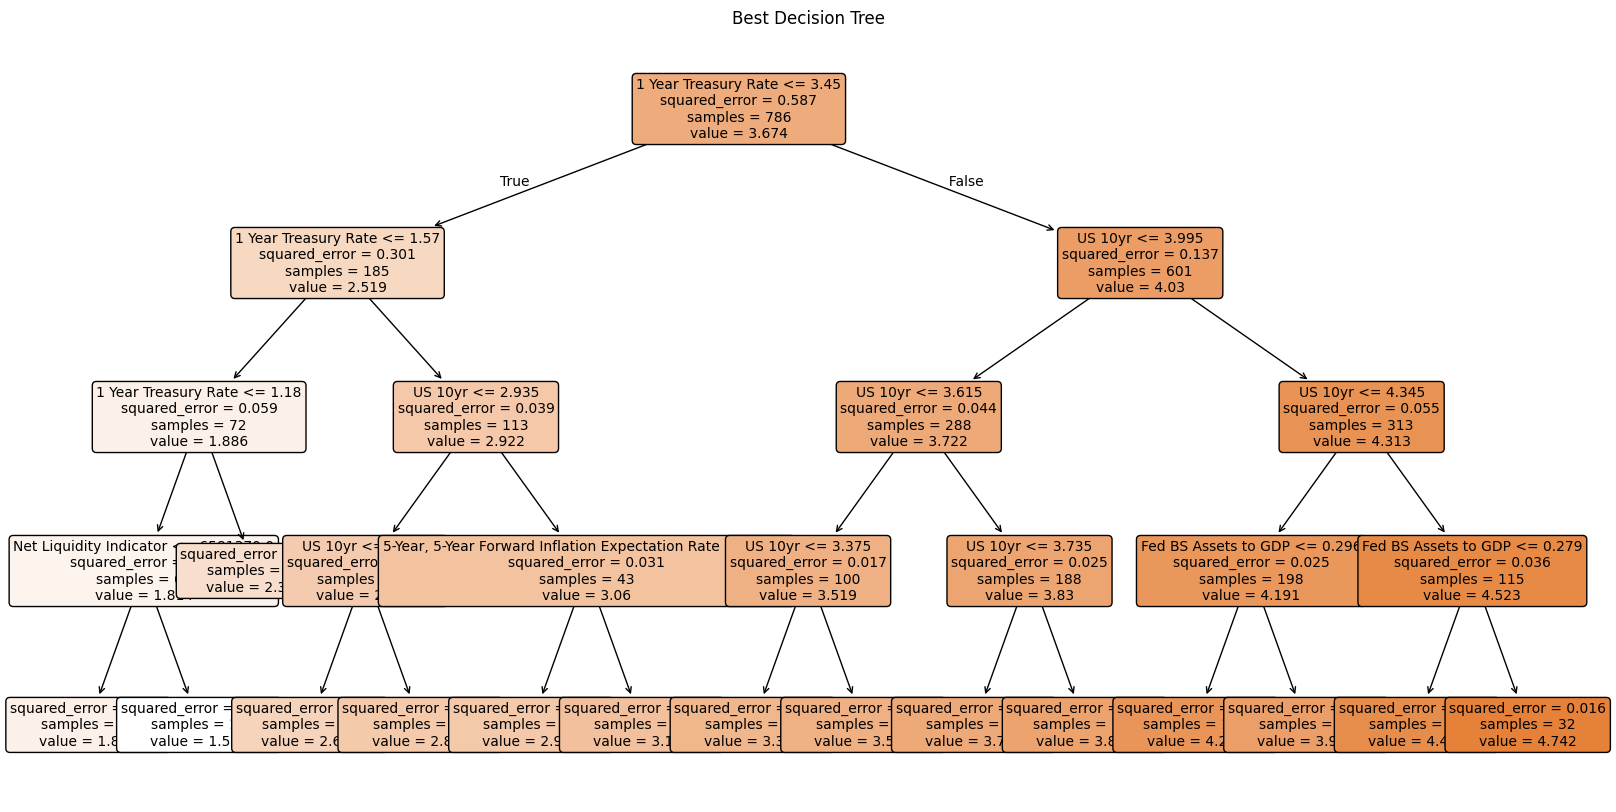

In [49]:
plt.figure(figsize=(20, 10))  # Adjust the size of the plot as necessary
plot_tree(best_tree, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.title("Best Decision Tree")
plt.show()


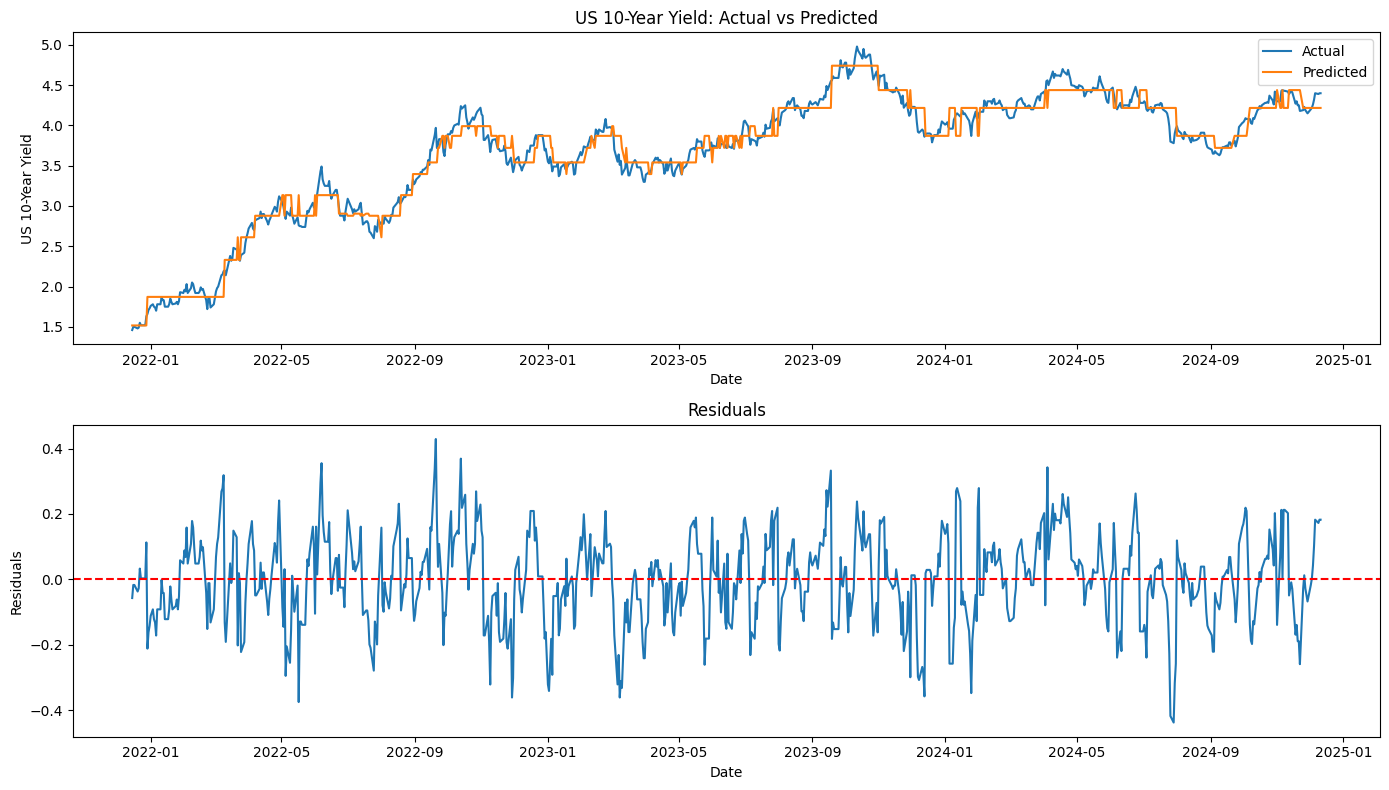

Model Parameters: {'max_depth': 4, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 10}
R^2: 0.9697413153069367
Adjusted R^2: 0.9694301720196045
Current 10-Year Yield: 4.4
Current 10-Year Yield Prediction: 4.2175
Percentile rank of the latest value: 92.25%


In [50]:
import matplotlib.dates as mdates

# Make predictions for the entire dataset
y_pred_all = best_tree.predict(X)

plt.figure(figsize=(14, 8))

# Plot actual vs predicted
plt.subplot(2, 1, 1)
plt.plot(df.index, y, label='Actual')
plt.plot(df.index, y_pred_all, label='Predicted')
plt.title('US 10-Year Yield: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('US 10-Year Yield')
plt.legend()

# Calculate residuals
residuals = y - y_pred_all

# Plot residuals
plt.subplot(2, 1, 2)
plt.plot(df.index, residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# Calculate R^2 and Adjusted R^2
r_squared = r2_score(y, y_pred_all)
n = X.shape[0]  # Number of observations
k = X.shape[1]  # Number of predictors
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)

# Calculate residuals
residuals = y - y_pred_all
df['residuals'] = residuals

# Calculate the percentile rank for each value in the series
df['residual percentile_rank'] = df['residuals'].rank(pct=True) * 100

# Retrieve the latest values
current_yield = round(y.iloc[-1], 4)
current_yield_prediction = round(y_pred_all[-1], 4)
latest_diff = round(current_yield - current_yield_prediction, 4)
latest_percentile_rank = df['residual percentile_rank'].iloc[-1]

# Display metrics
print(f"Model Parameters: {best_params}")
print(f"R^2: {r_squared}")
print(f"Adjusted R^2: {adjusted_r_squared}")
print(f"Current 10-Year Yield: {current_yield}")
print(f"Current 10-Year Yield Prediction: {current_yield_prediction}")
print(f"Percentile rank of the latest value: {latest_percentile_rank:.2f}%")

In [51]:
# make predictions with alternative values
X2 = X.tail(1).copy()
X2.loc[X2.index[0],'Summary of Economic Projections: Longer-Term Federal Funds Rate'] = 3.0
print(best_tree.predict(X2))

[4.21748571]
